In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.1424
0 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 1 -> 6 -> 13 -> 19 -> 11 -> 18 -> 7 -> 2 -> 14 -> 12 -> 4 -> 9 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.29it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 116.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.99it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.67it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from clipgrad import clipGrad

def pipeline(reg, optimizer, forward_func, loss_func, num_epochs, log_step,
             loader_train, loader_val, loader_test, seed=42, grad_clip=False):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip gradients
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, regret_trn*100, regret_val*100))
    # load best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

### Large Learning Rate 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

(CVXPY) Dec 02 06:48:39 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [14]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)

In [15]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, optimizer, forwardCAVE, ca_cos, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 216.6579%, Val Regret: 224.0108%


Epoch    0, Loss:  -0.9970:   5%|██▊                                                    | 1/20 [00:29<06:19, 19.96s/it]

Epoch   1, Train Regret:  12.7627%, Val Regret:  14.4853%


Epoch    1, Loss:  -0.9988:  10%|█████▌                                                 | 2/20 [00:42<04:44, 15.81s/it]

Epoch   2, Train Regret:   8.4656%, Val Regret:   9.7859%


Epoch    2, Loss:  -0.9989:  15%|████████▎                                              | 3/20 [00:55<04:08, 14.59s/it]

Epoch   3, Train Regret:   7.3574%, Val Regret:   8.5652%


Epoch    3, Loss:  -0.9993:  20%|███████████                                            | 4/20 [01:08<03:45, 14.08s/it]

Epoch   4, Train Regret:   7.2844%, Val Regret:   8.2889%


Epoch    4, Loss:  -0.9995:  25%|█████████████▊                                         | 5/20 [01:22<03:26, 13.79s/it]

Epoch   5, Train Regret:   6.9044%, Val Regret:   7.7126%


Epoch    5, Loss:  -0.9995:  30%|████████████████▌                                      | 6/20 [01:37<03:11, 13.69s/it]

Epoch   6, Train Regret:   6.9564%, Val Regret:   7.8963%


Epoch    6, Loss:  -0.9992:  35%|███████████████████▎                                   | 7/20 [01:50<03:02, 14.08s/it]

Epoch   7, Train Regret:   6.9686%, Val Regret:   7.5158%


Epoch    7, Loss:  -0.9993:  40%|██████████████████████                                 | 8/20 [02:03<02:46, 13.91s/it]

Epoch   8, Train Regret:   6.7925%, Val Regret:   8.0638%


Epoch    8, Loss:  -0.9996:  45%|████████████████████████▊                              | 9/20 [02:17<02:29, 13.60s/it]

Epoch   9, Train Regret:   7.0060%, Val Regret:   8.2656%


Epoch    9, Loss:  -0.9996:  50%|███████████████████████████                           | 10/20 [02:30<02:15, 13.51s/it]

Epoch  10, Train Regret:   6.9678%, Val Regret:   8.1496%


Epoch   10, Loss:  -0.9995:  55%|█████████████████████████████▋                        | 11/20 [02:43<02:00, 13.42s/it]

Epoch  11, Train Regret:   6.7632%, Val Regret:   7.8830%


Epoch   11, Loss:  -0.9996:  60%|████████████████████████████████▍                     | 12/20 [02:57<01:47, 13.43s/it]

Epoch  12, Train Regret:   6.7746%, Val Regret:   7.7099%


Epoch   12, Loss:  -0.9996:  65%|███████████████████████████████████                   | 13/20 [03:10<01:33, 13.37s/it]

Epoch  13, Train Regret:   6.9658%, Val Regret:   7.9203%


Epoch   13, Loss:  -0.9996:  70%|█████████████████████████████████████▊                | 14/20 [03:23<01:20, 13.36s/it]

Epoch  14, Train Regret:   7.0572%, Val Regret:   7.6945%


Epoch   14, Loss:  -0.9998:  75%|████████████████████████████████████████▌             | 15/20 [03:37<01:06, 13.37s/it]

Epoch  15, Train Regret:   6.9669%, Val Regret:   7.8548%


Epoch   15, Loss:  -0.9997:  80%|███████████████████████████████████████████▏          | 16/20 [03:51<00:54, 13.62s/it]

Epoch  16, Train Regret:   6.8699%, Val Regret:   7.8278%


Epoch   16, Loss:  -0.9997:  85%|█████████████████████████████████████████████▉        | 17/20 [04:04<00:40, 13.58s/it]

Epoch  17, Train Regret:   7.0470%, Val Regret:   8.2432%


Epoch   17, Loss:  -0.9998:  90%|████████████████████████████████████████████████▌     | 18/20 [04:18<00:26, 13.43s/it]

Epoch  18, Train Regret:   6.8903%, Val Regret:   8.3074%


Epoch   18, Loss:  -0.9998:  95%|███████████████████████████████████████████████████▎  | 19/20 [04:31<00:13, 13.51s/it]

Epoch  19, Train Regret:   7.0060%, Val Regret:   8.2919%


Epoch   19, Loss:  -0.9998: 100%|██████████████████████████████████████████████████████| 20/20 [04:35<00:00, 13.77s/it]


Epoch  19, Train Regret:   7.1602%, Val Regret:   8.6913%

Evaluation:
Test Regret: 7.3849%
Training Elapsed Time: 59.25 Sec


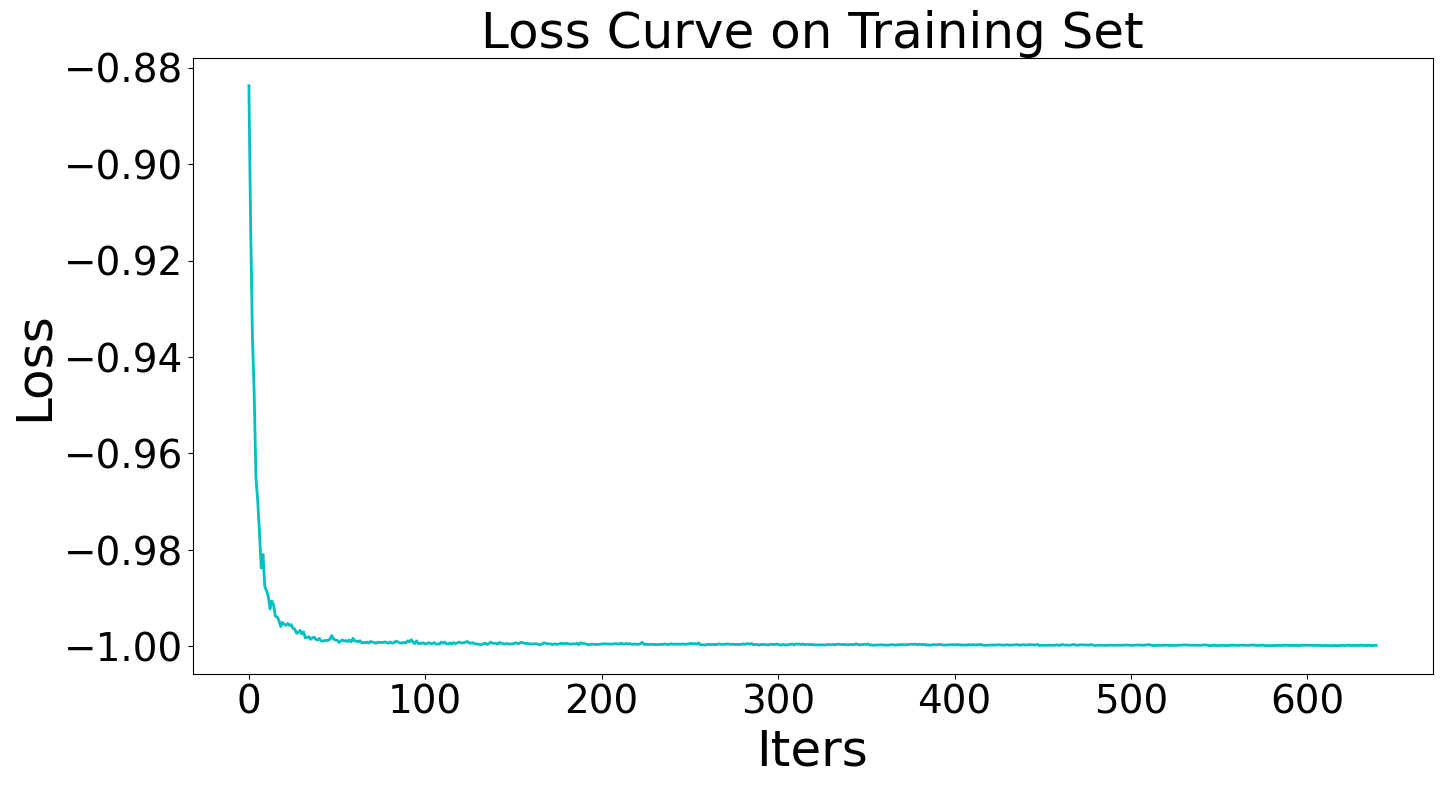

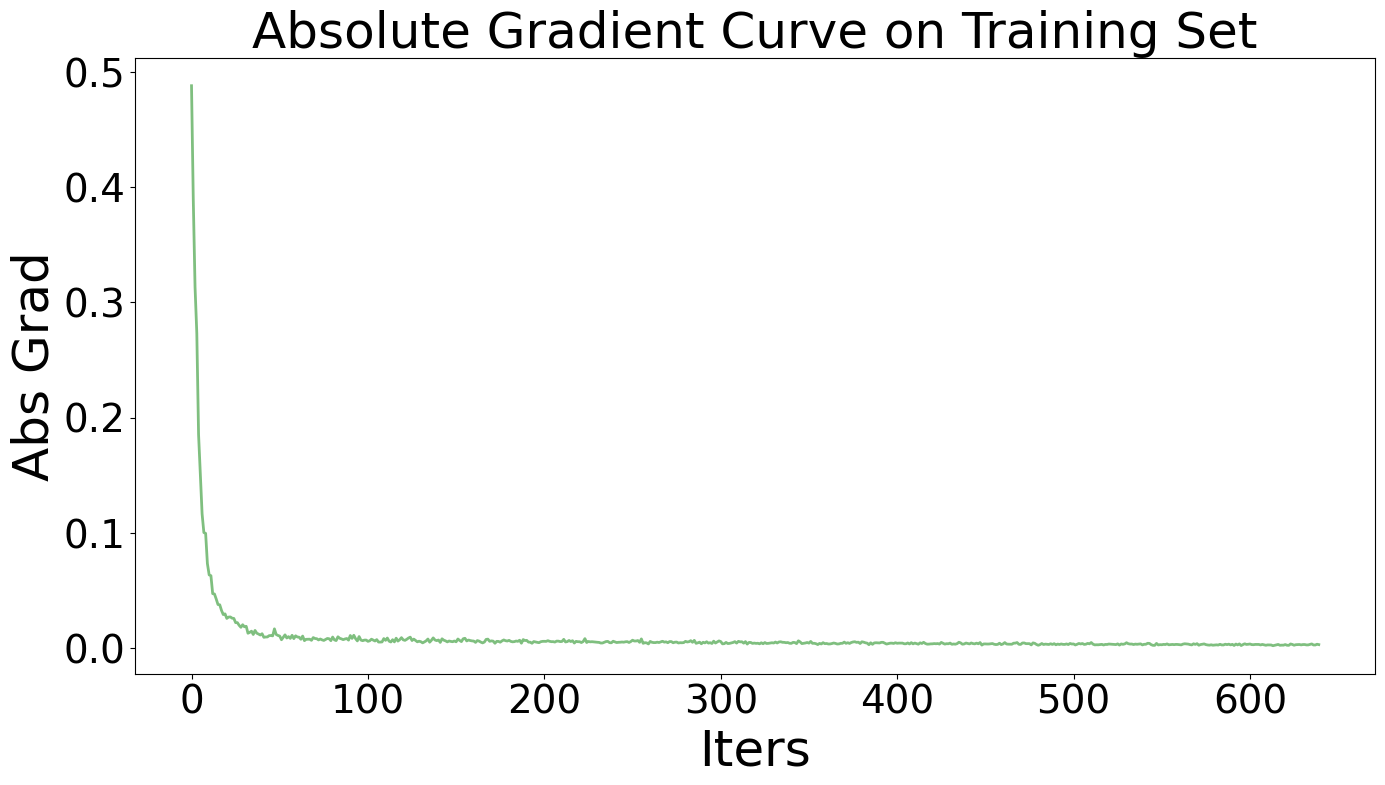

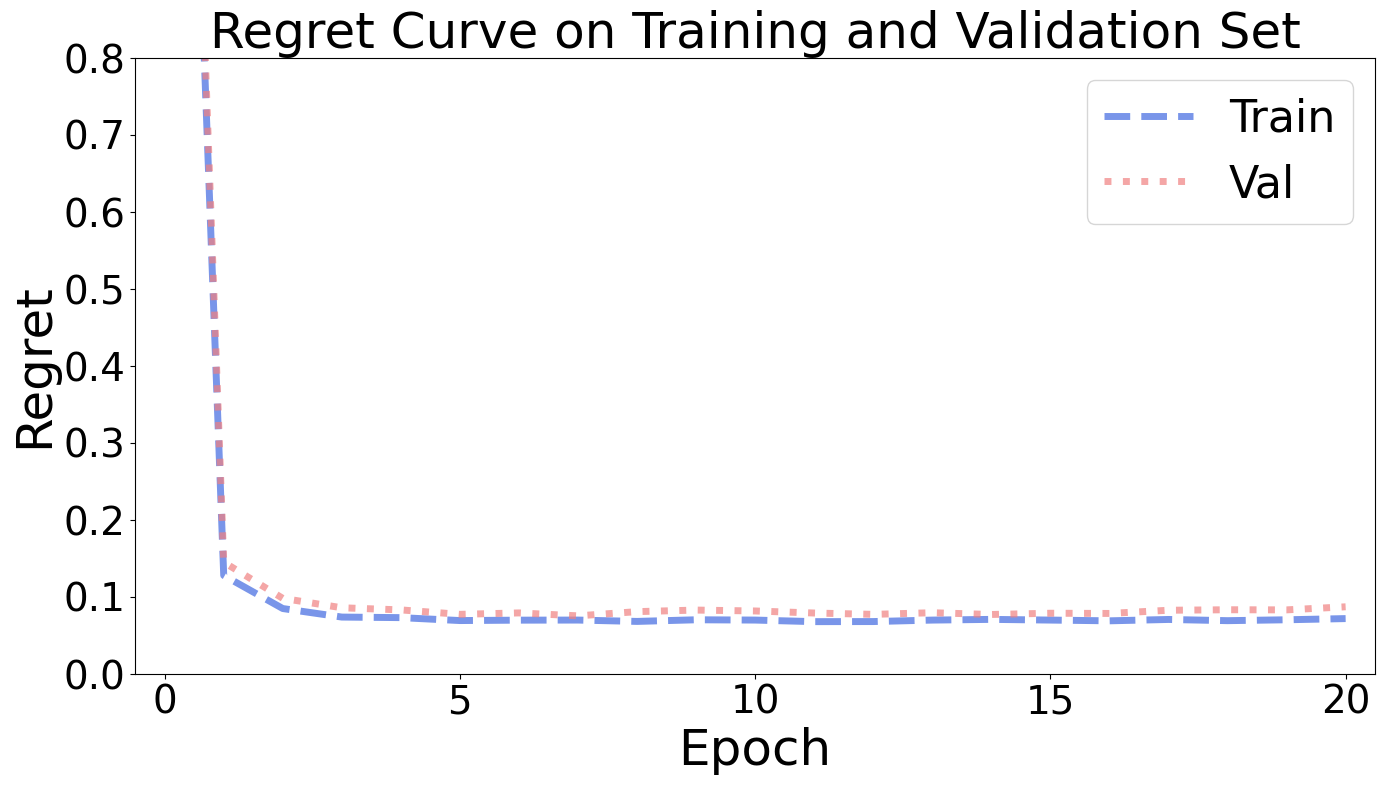

In [16]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

In [17]:
# change learning rate
for param_group in optimizer.param_groups:
            param_group["lr"] = 5e0

In [18]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, optimizer, forwardCAVE, ca_cos, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret:   6.9686%, Val Regret:   7.5158%


Epoch    0, Loss:  -0.9961:   5%|██▊                                                    | 1/20 [00:22<04:12, 13.27s/it]

Epoch   1, Train Regret:  19.3299%, Val Regret:  19.8474%


Epoch    1, Loss:  -0.9975:  10%|█████▌                                                 | 2/20 [00:36<03:59, 13.33s/it]

Epoch   2, Train Regret:  12.7146%, Val Regret:  13.3648%


Epoch    2, Loss:  -0.9983:  15%|████████▎                                              | 3/20 [00:50<03:48, 13.44s/it]

Epoch   3, Train Regret:  10.4476%, Val Regret:  11.9471%


Epoch    3, Loss:  -0.9994:  20%|███████████                                            | 4/20 [01:03<03:39, 13.69s/it]

Epoch   4, Train Regret:   9.5992%, Val Regret:  10.1171%


Epoch    4, Loss:  -0.9988:  25%|█████████████▊                                         | 5/20 [01:16<03:21, 13.44s/it]

Epoch   5, Train Regret:   8.7903%, Val Regret:   8.8484%


Epoch    5, Loss:  -0.9996:  30%|████████████████▌                                      | 6/20 [01:29<03:06, 13.31s/it]

Epoch   6, Train Regret:   8.2153%, Val Regret:   8.5004%


Epoch    6, Loss:  -0.9993:  35%|███████████████████▎                                   | 7/20 [01:43<02:51, 13.22s/it]

Epoch   7, Train Regret:   7.9594%, Val Regret:   8.3329%


Epoch    7, Loss:  -0.9994:  40%|██████████████████████                                 | 8/20 [01:56<02:38, 13.21s/it]

Epoch   8, Train Regret:   7.7189%, Val Regret:   8.4878%


Epoch    8, Loss:  -0.9996:  45%|████████████████████████▊                              | 9/20 [02:08<02:24, 13.15s/it]

Epoch   9, Train Regret:   7.6640%, Val Regret:   8.0458%


Epoch    9, Loss:  -0.9996:  50%|███████████████████████████                           | 10/20 [02:22<02:10, 13.09s/it]

Epoch  10, Train Regret:   7.4345%, Val Regret:   7.9506%


Epoch   10, Loss:  -0.9995:  55%|█████████████████████████████▋                        | 11/20 [02:35<01:57, 13.09s/it]

Epoch  11, Train Regret:   7.3422%, Val Regret:   7.9356%


Epoch   11, Loss:  -0.9995:  60%|████████████████████████████████▍                     | 12/20 [02:49<01:46, 13.32s/it]

Epoch  12, Train Regret:   7.2872%, Val Regret:   7.4753%


Epoch   12, Loss:  -0.9996:  65%|███████████████████████████████████                   | 13/20 [03:02<01:34, 13.43s/it]

Epoch  13, Train Regret:   7.2556%, Val Regret:   7.3261%


Epoch   13, Loss:  -0.9996:  70%|█████████████████████████████████████▊                | 14/20 [03:15<01:19, 13.28s/it]

Epoch  14, Train Regret:   7.2153%, Val Regret:   7.3787%


Epoch   14, Loss:  -0.9994:  75%|████████████████████████████████████████▌             | 15/20 [03:28<01:05, 13.14s/it]

Epoch  15, Train Regret:   7.2468%, Val Regret:   7.3505%


Epoch   15, Loss:  -0.9996:  80%|███████████████████████████████████████████▏          | 16/20 [03:41<00:52, 13.16s/it]

Epoch  16, Train Regret:   7.2077%, Val Regret:   7.2552%


Epoch   16, Loss:  -0.9996:  85%|█████████████████████████████████████████████▉        | 17/20 [03:54<00:39, 13.18s/it]

Epoch  17, Train Regret:   7.1044%, Val Regret:   7.4456%


Epoch   17, Loss:  -0.9997:  90%|████████████████████████████████████████████████▌     | 18/20 [04:08<00:26, 13.16s/it]

Epoch  18, Train Regret:   7.0582%, Val Regret:   7.2923%


Epoch   18, Loss:  -0.9996:  95%|███████████████████████████████████████████████████▎  | 19/20 [04:21<00:13, 13.15s/it]

Epoch  19, Train Regret:   7.2294%, Val Regret:   7.3835%


Epoch   19, Loss:  -0.9996: 100%|██████████████████████████████████████████████████████| 20/20 [04:24<00:00, 13.23s/it]


Epoch  19, Train Regret:   7.2204%, Val Regret:   7.1776%

Evaluation:
Test Regret: 7.6379%
Training Elapsed Time: 51.17 Sec


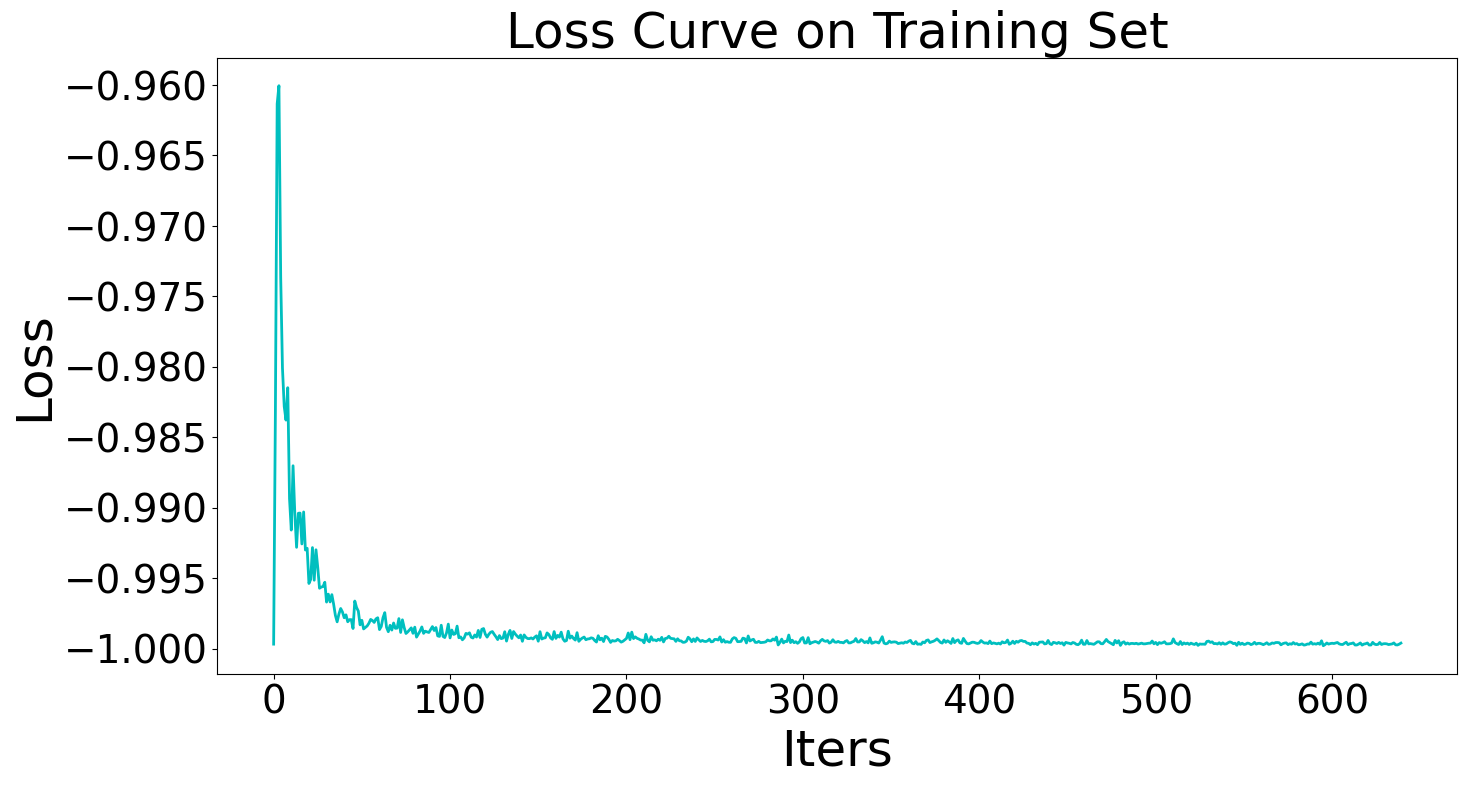

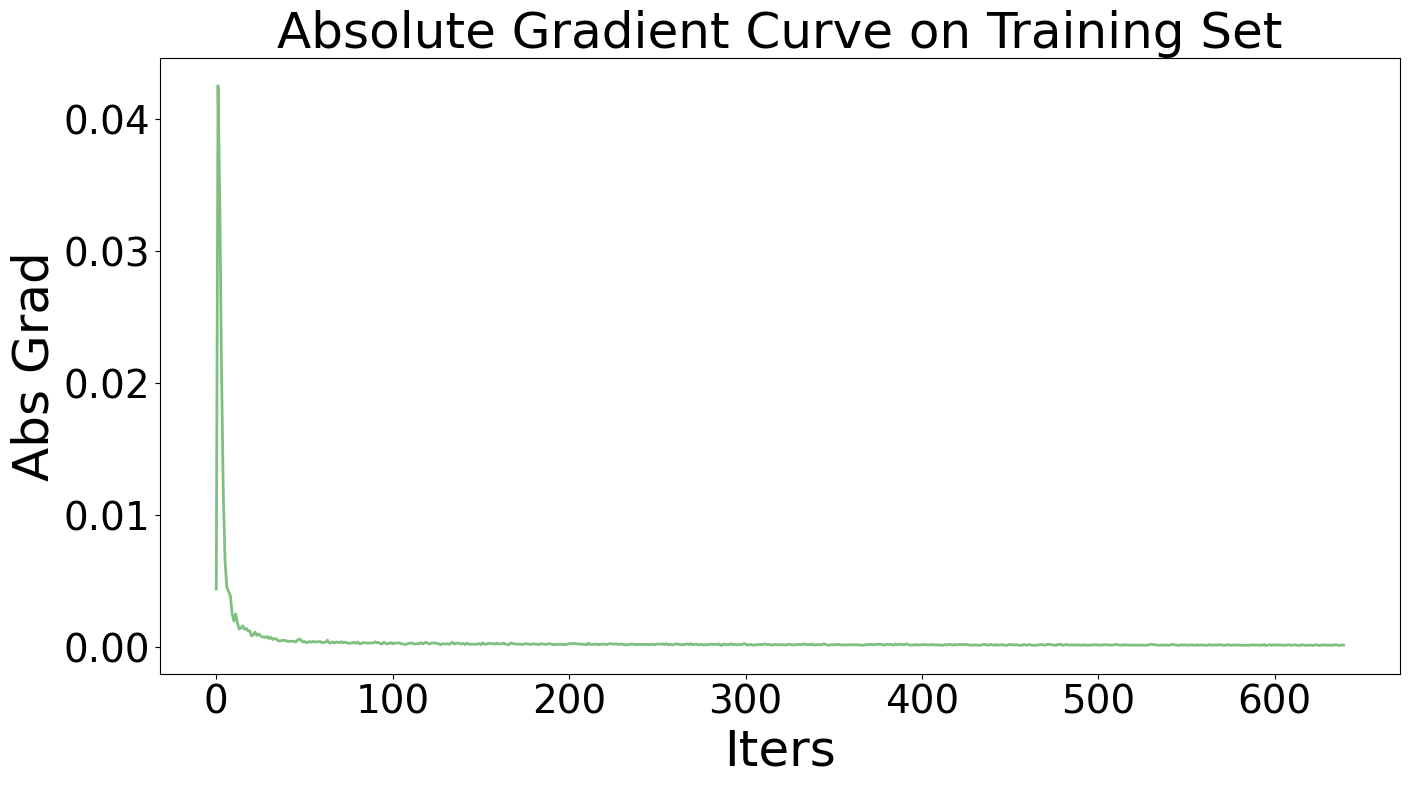

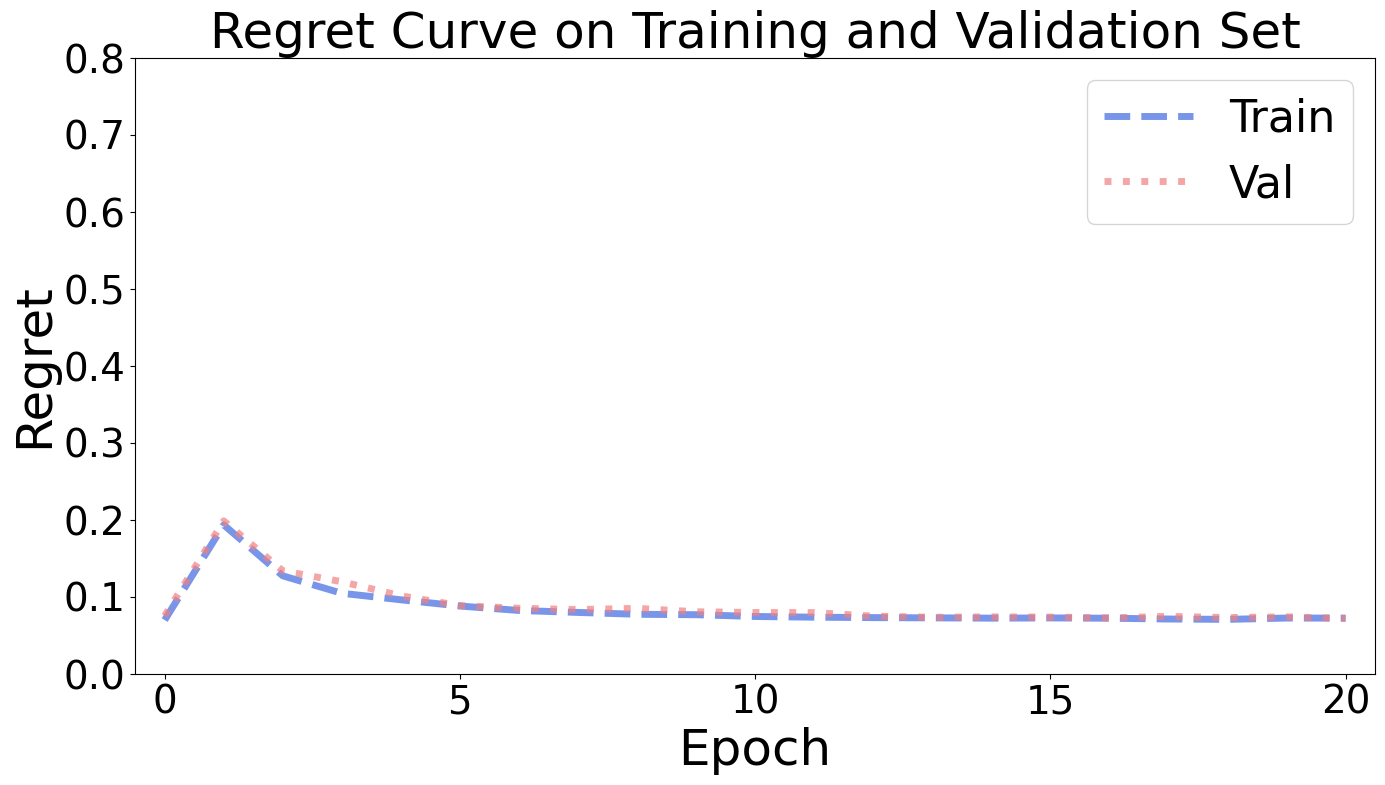

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Gradient Clip 

In [20]:
# init model
reg = LinearRegression()

In [21]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)

In [22]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, optimizer, forwardCAVE, ca_cos, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 193.5329%, Val Regret: 199.5133%


Epoch    0, Loss:  -0.9983:   5%|██▊                                                    | 1/20 [00:23<04:11, 13.24s/it]

Epoch   1, Train Regret:  11.5678%, Val Regret:  12.4432%


Epoch    1, Loss:  -0.9990:  10%|█████▌                                                 | 2/20 [00:36<03:59, 13.31s/it]

Epoch   2, Train Regret:   7.6912%, Val Regret:   8.0851%


Epoch    2, Loss:  -0.9991:  15%|████████▎                                              | 3/20 [00:49<03:45, 13.26s/it]

Epoch   3, Train Regret:   6.9931%, Val Regret:   8.3946%


Epoch    3, Loss:  -0.9994:  20%|███████████                                            | 4/20 [01:02<03:31, 13.24s/it]

Epoch   4, Train Regret:   6.6543%, Val Regret:   7.6799%


Epoch    4, Loss:  -0.9995:  25%|█████████████▊                                         | 5/20 [01:15<03:17, 13.18s/it]

Epoch   5, Train Regret:   6.6679%, Val Regret:   7.3708%


Epoch    5, Loss:  -0.9996:  30%|████████████████▌                                      | 6/20 [01:29<03:05, 13.23s/it]

Epoch   6, Train Regret:   6.6996%, Val Regret:   7.4855%


Epoch    6, Loss:  -0.9990:  35%|███████████████████▎                                   | 7/20 [01:42<02:51, 13.19s/it]

Epoch   7, Train Regret:   6.7052%, Val Regret:   7.2400%


Epoch    7, Loss:  -0.9995:  40%|██████████████████████                                 | 8/20 [01:57<02:38, 13.17s/it]

Epoch   8, Train Regret:   6.6171%, Val Regret:   6.9167%


Epoch    8, Loss:  -0.9996:  45%|████████████████████████▊                              | 9/20 [02:10<02:31, 13.76s/it]

Epoch   9, Train Regret:   6.7127%, Val Regret:   7.2567%


Epoch    9, Loss:  -0.9996:  50%|███████████████████████████                           | 10/20 [02:24<02:17, 13.73s/it]

Epoch  10, Train Regret:   6.7171%, Val Regret:   6.9062%


Epoch   10, Loss:  -0.9996:  55%|█████████████████████████████▋                        | 11/20 [02:37<02:02, 13.61s/it]

Epoch  11, Train Regret:   6.7839%, Val Regret:   6.9223%


Epoch   11, Loss:  -0.9997:  60%|████████████████████████████████▍                     | 12/20 [02:50<01:47, 13.46s/it]

Epoch  12, Train Regret:   6.8294%, Val Regret:   6.8744%


Epoch   12, Loss:  -0.9997:  65%|███████████████████████████████████                   | 13/20 [03:03<01:33, 13.33s/it]

Epoch  13, Train Regret:   6.8725%, Val Regret:   7.0484%


Epoch   13, Loss:  -0.9996:  70%|█████████████████████████████████████▊                | 14/20 [03:16<01:19, 13.20s/it]

Epoch  14, Train Regret:   6.9634%, Val Regret:   6.7935%


Epoch   14, Loss:  -0.9998:  75%|████████████████████████████████████████▌             | 15/20 [03:29<01:05, 13.16s/it]

Epoch  15, Train Regret:   6.8064%, Val Regret:   7.1455%


Epoch   15, Loss:  -0.9997:  80%|███████████████████████████████████████████▏          | 16/20 [03:42<00:52, 13.16s/it]

Epoch  16, Train Regret:   6.8729%, Val Regret:   6.9857%


Epoch   16, Loss:  -0.9998:  85%|█████████████████████████████████████████████▉        | 17/20 [03:57<00:39, 13.21s/it]

Epoch  17, Train Regret:   6.9516%, Val Regret:   7.4326%


Epoch   17, Loss:  -0.9998:  90%|████████████████████████████████████████████████▌     | 18/20 [04:11<00:27, 13.84s/it]

Epoch  18, Train Regret:   6.8126%, Val Regret:   7.3786%


Epoch   18, Loss:  -0.9998:  95%|███████████████████████████████████████████████████▎  | 19/20 [04:24<00:13, 13.78s/it]

Epoch  19, Train Regret:   7.0556%, Val Regret:   7.4098%


Epoch   19, Loss:  -0.9998: 100%|██████████████████████████████████████████████████████| 20/20 [04:28<00:00, 13.41s/it]


Epoch  19, Train Regret:   7.2024%, Val Regret:   8.1647%

Evaluation:
Test Regret: 7.3546%
Training Elapsed Time: 51.12 Sec


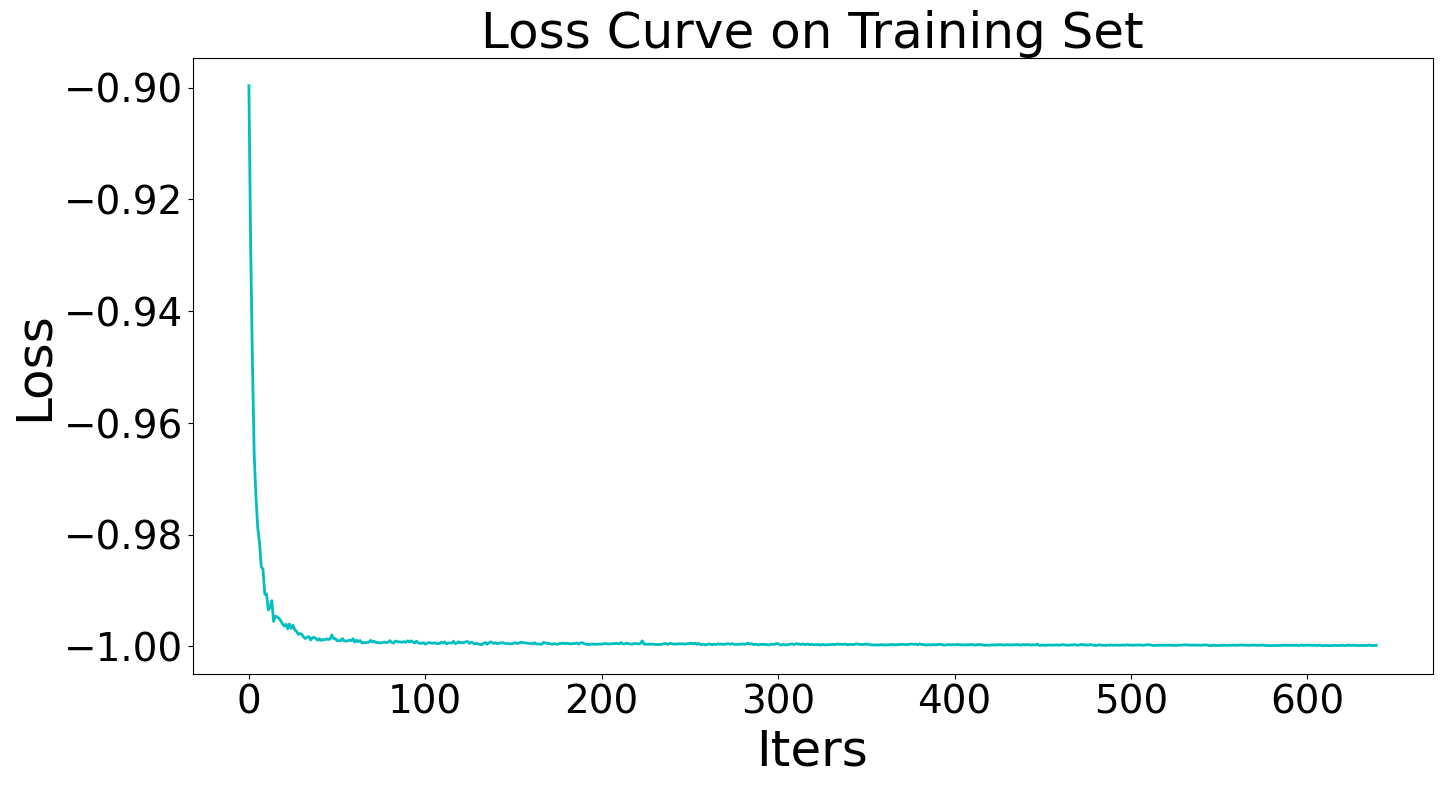

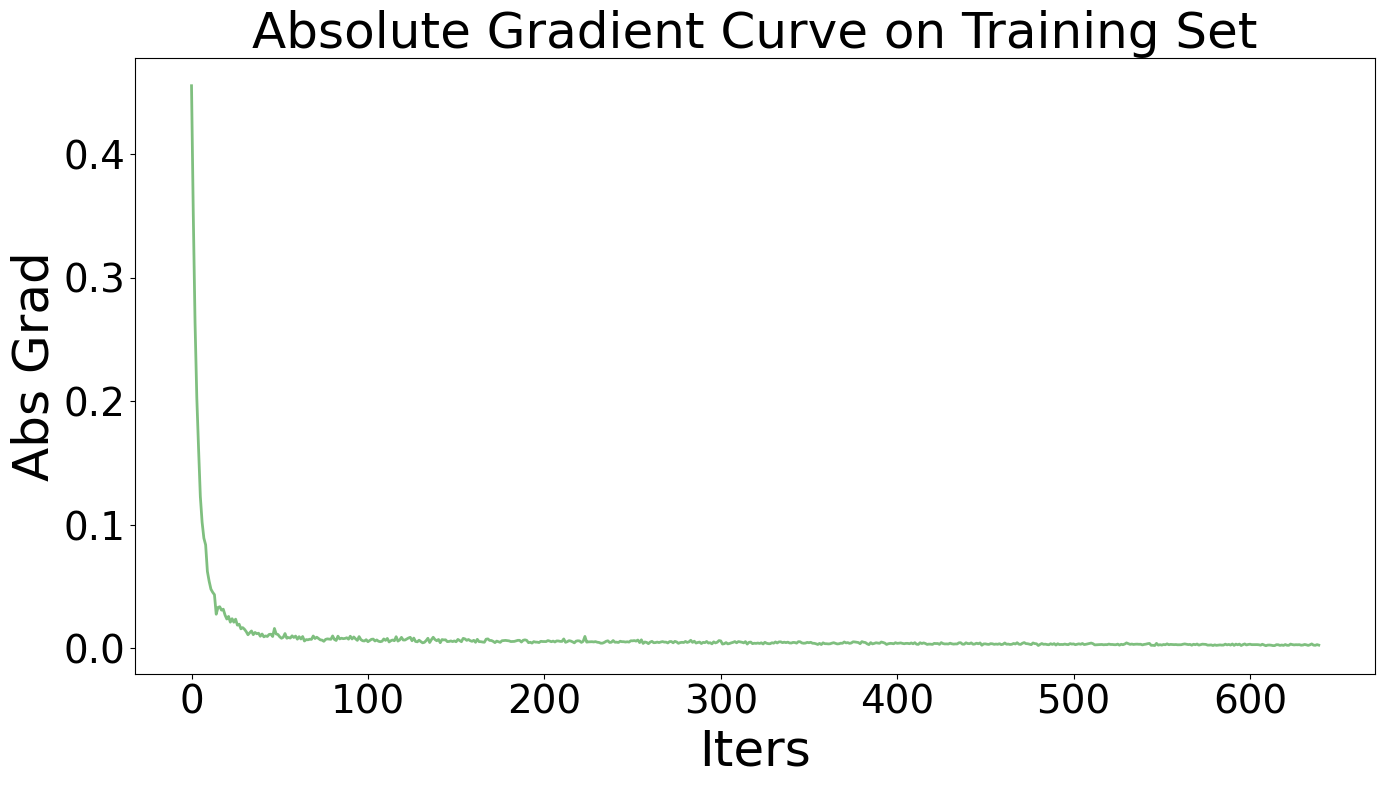

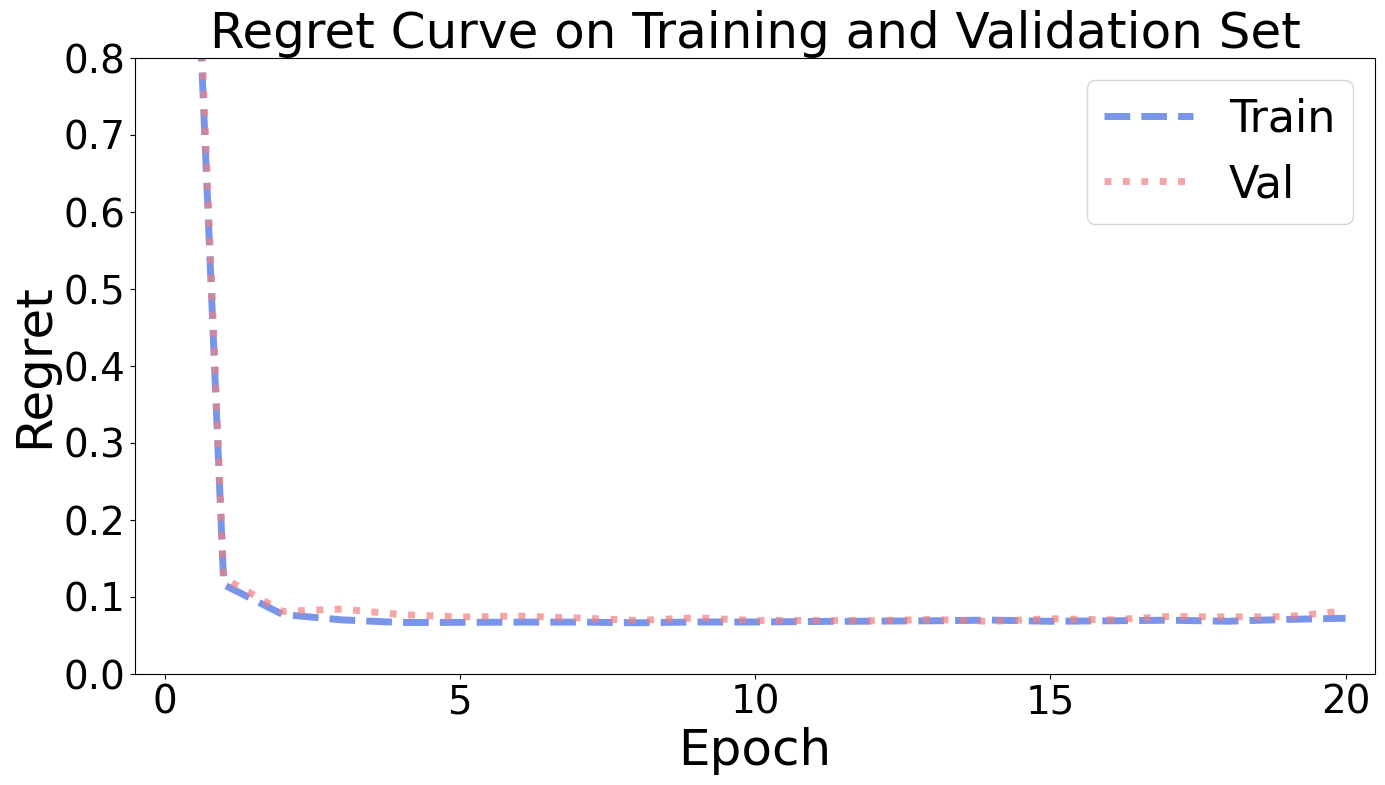

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

In [24]:
# change learning rate
for param_group in optimizer.param_groups:
            param_group["lr"] = 5e0

In [25]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, optimizer, forwardCAVE, ca_cos, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret:   6.9634%, Val Regret:   6.7935%


Epoch    0, Loss:  -0.9938:   5%|██▊                                                    | 1/20 [00:22<04:09, 13.12s/it]

Epoch   1, Train Regret:  17.4974%, Val Regret:  19.8734%


Epoch    1, Loss:  -0.9972:  10%|█████▌                                                 | 2/20 [00:35<03:56, 13.13s/it]

Epoch   2, Train Regret:  11.8811%, Val Regret:  12.4812%


Epoch    2, Loss:  -0.9974:  15%|████████▎                                              | 3/20 [00:48<03:43, 13.17s/it]

Epoch   3, Train Regret:  10.2148%, Val Regret:  10.7393%


Epoch    3, Loss:  -0.9994:  20%|███████████                                            | 4/20 [01:02<03:29, 13.10s/it]

Epoch   4, Train Regret:   9.1791%, Val Regret:   9.3702%


Epoch    4, Loss:  -0.9994:  25%|█████████████▊                                         | 5/20 [01:16<03:18, 13.23s/it]

Epoch   5, Train Regret:   8.6009%, Val Regret:   8.6173%


Epoch    5, Loss:  -0.9997:  30%|████████████████▌                                      | 6/20 [01:29<03:10, 13.61s/it]

Epoch   6, Train Regret:   8.2359%, Val Regret:   8.3209%


Epoch    6, Loss:  -0.9990:  35%|███████████████████▎                                   | 7/20 [01:42<02:54, 13.44s/it]

Epoch   7, Train Regret:   7.9537%, Val Regret:   8.1880%


Epoch    7, Loss:  -0.9992:  40%|██████████████████████                                 | 8/20 [01:55<02:39, 13.27s/it]

Epoch   8, Train Regret:   7.7049%, Val Regret:   7.9178%


Epoch    8, Loss:  -0.9995:  45%|████████████████████████▊                              | 9/20 [02:08<02:25, 13.21s/it]

Epoch   9, Train Regret:   7.4731%, Val Regret:   7.7737%


Epoch    9, Loss:  -0.9996:  50%|███████████████████████████                           | 10/20 [02:21<02:11, 13.18s/it]

Epoch  10, Train Regret:   7.2784%, Val Regret:   7.5067%


Epoch   10, Loss:  -0.9996:  55%|█████████████████████████████▋                        | 11/20 [02:34<01:57, 13.10s/it]

Epoch  11, Train Regret:   7.1829%, Val Regret:   7.5551%


Epoch   11, Loss:  -0.9996:  60%|████████████████████████████████▍                     | 12/20 [02:48<01:44, 13.10s/it]

Epoch  12, Train Regret:   7.0719%, Val Regret:   7.4261%


Epoch   12, Loss:  -0.9996:  65%|███████████████████████████████████                   | 13/20 [03:02<01:32, 13.16s/it]

Epoch  13, Train Regret:   7.1736%, Val Regret:   7.2361%


Epoch   13, Loss:  -0.9997:  70%|█████████████████████████████████████▊                | 14/20 [03:17<01:20, 13.48s/it]

Epoch  14, Train Regret:   7.0834%, Val Regret:   7.3847%


Epoch   14, Loss:  -0.9995:  75%|████████████████████████████████████████▌             | 15/20 [03:30<01:09, 13.89s/it]

Epoch  15, Train Regret:   7.0551%, Val Regret:   7.4534%


Epoch   15, Loss:  -0.9997:  80%|███████████████████████████████████████████▏          | 16/20 [03:43<00:54, 13.73s/it]

Epoch  16, Train Regret:   7.0899%, Val Regret:   7.7195%


Epoch   16, Loss:  -0.9996:  85%|█████████████████████████████████████████████▉        | 17/20 [03:57<00:40, 13.63s/it]

Epoch  17, Train Regret:   6.9588%, Val Regret:   7.5952%


Epoch   17, Loss:  -0.9997:  90%|████████████████████████████████████████████████▌     | 18/20 [04:10<00:27, 13.52s/it]

Epoch  18, Train Regret:   7.0446%, Val Regret:   7.4056%


Epoch   18, Loss:  -0.9995:  95%|███████████████████████████████████████████████████▎  | 19/20 [04:23<00:13, 13.36s/it]

Epoch  19, Train Regret:   6.9891%, Val Regret:   7.2498%


Epoch   19, Loss:  -0.9996: 100%|██████████████████████████████████████████████████████| 20/20 [04:26<00:00, 13.34s/it]


Epoch  19, Train Regret:   6.9180%, Val Regret:   7.2491%

Evaluation:
Test Regret: 7.3546%
Training Elapsed Time: 51.21 Sec


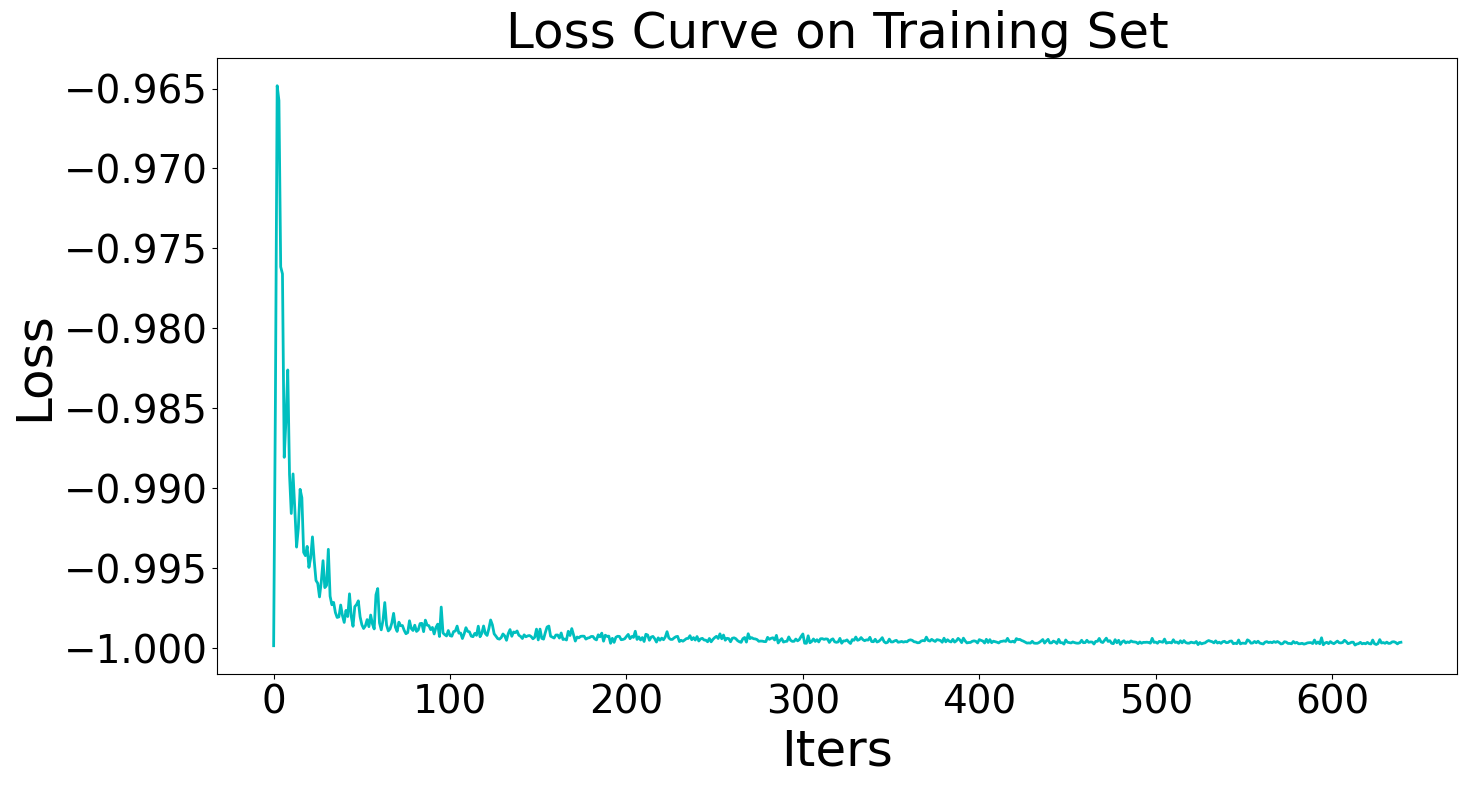

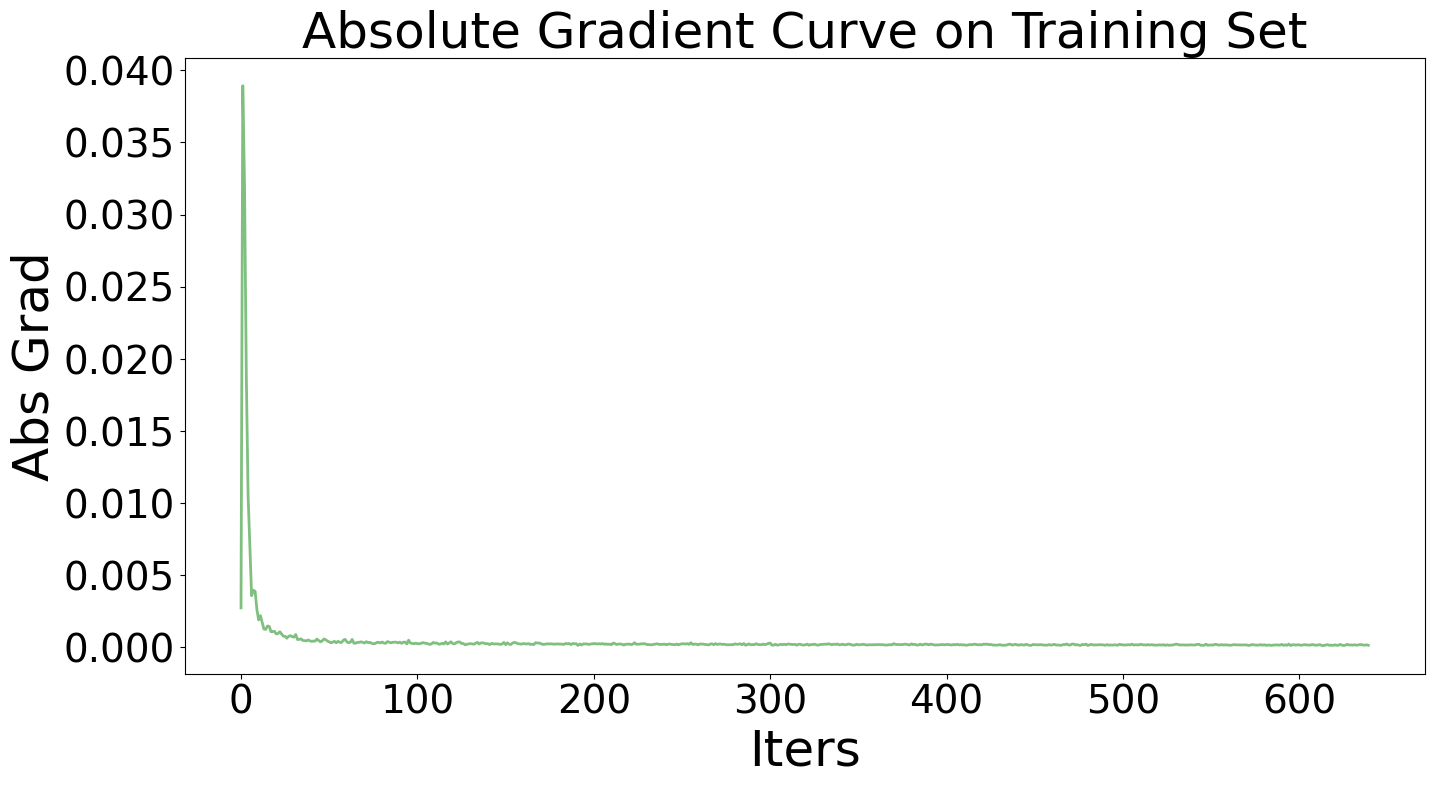

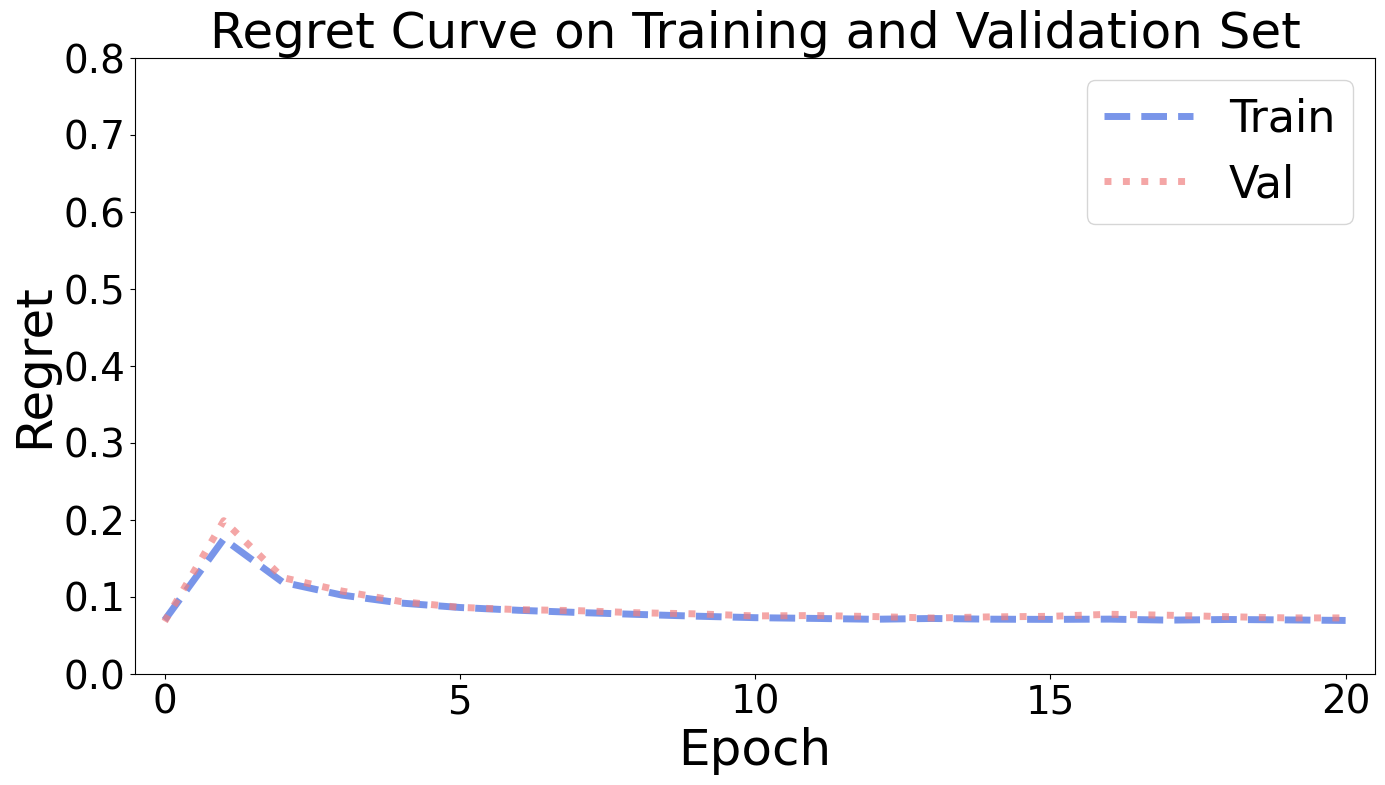

In [26]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)